# import modules

In [24]:
import keras
from keras.utils import plot_model,to_categorical
from keras import Model,Input,regularizers
from keras.layers import Reshape,Flatten
import numpy as np
from sklearn.model_selection import train_test_split
import keras.backend as K
import keras.callbacks as kcallbacks
from sklearn.preprocessing import LabelEncoder
import string
from keras.optimizers import SGD
import warnings
import tensorflow as tf
# from lsuv_init import LSUVinit
warnings.filterwarnings('ignore')
from tensorflow.keras import layers
from keras.layers import Input, Dense, LSTM, merge ,Conv1D,Dropout,Bidirectional,Multiply,BatchNormalization,MaxPool1D,Concatenate,TimeDistributed
from keras.models import Model


from attention_utils import get_activations
from keras.layers import merge
from keras.layers.core import *
from keras.layers.recurrent import LSTM
from keras.models import *

import  pandas as pd
import  numpy as np
from keras.wrappers import scikit_learn
warnings.filterwarnings('ignore')

# Load Features

In [16]:
alphabet_set={'0': 0,'b': 1, 'c': 2,'d': 3,'f': 4,'g': 5,'h': 6,'j': 7,'k': 8,'l': 9, 'm': 10,'n': 11,'p': 12,'q': 13,
          'r': 14,'s': 15,'t': 16,'w': 17,'x': 18,'y': 19,'z': 20}

In [17]:
alphabet_set={value:key for key,value in alphabet_set.items()}

## One-hot Encoding

## split train and test

# Models


In [18]:
X_gabor = np.load('.\\feature\\X_gabor.npy')
X_gabor_train,X_gabor_val= train_test_split(X_gabor,test_size=0.1,random_state=2019)
X_mfcc= np.load('.\\feature\\X_feature.npy')
y_initial= np.load('.\\feature\\y_initial.npy')
X_mfcc_train,X_mfcc_val,y_initial_train,y_initial_val=train_test_split(X_mfcc,y_initial,test_size=0.1,random_state=2019)

In [19]:
#y_initial_train =np.load('./feature/y_initial_train.npy')
#y_initial_val =np.load('./feature/y_initial_validation.npy')
y_initial_train=to_categorical(y_initial_train,num_classes=21)
y_initial_val=to_categorical(y_initial_val,num_classes=21)

In [20]:
y_initial_train.shape

(4233, 2, 21)

In [21]:
##X_mfcc_train=np.load('./feature/mfcc_fusion_train.npy')
##X_mfcc_val=np.load('./feature/mfcc_fusion_validation.npy')

In [22]:
NUM_CLASSES=21
BATCH_SIZE=128
EPOCHS=100
MODEL_SAVE_PATH='.\models\early_merged_initial_cnn.h5'


In [36]:
K.clear_session()
inputs1=Input(shape=(35,7),name='inputs_gabor')
x=BatchNormalization()(inputs1)
x = Conv1D(filters = 64, kernel_size = 1, padding="same",kernel_initializer='he_normal',
                bias_initializer='zeros',activation = 'relu')(x)  #, padding = 'same'
x = MaxPool1D()(x)
#lstm_out = Bidirectional(LSTM(lstm_units, activation='relu'), name='bilstm')(x)
#对于GPU可以使用CuDNNLSTM
lstm_out = Bidirectional(LSTM(128, return_sequences=True,dropout=0.4))(x)
lstm_out = Dropout(0.3)(lstm_out)
attention_mul = attention_3d_block(lstm_out)
attention_mul = MaxPool1D(pool_size=12,strides=4)(attention_mul)
out_gabor = Dense(100, activation='sigmoid',name='gabor')(attention_mul)


inputs2=Input(shape=(50,57),name='inputs_mfcc')
x = BatchNormalization()(inputs2)
x = Conv1D(filters = 64, kernel_size = 1, activation = 'relu')(x)  #, padding = 'same'
x = Dropout(0.3)(x)
#lstm_out = Bidirectional(LSTM(lstm_units, activation='relu'), name='bilstm')(x)
#对于GPU可以使用CuDNNLSTM
lstm_out = Bidirectional(LSTM(64, return_sequences=True))(x)
lstm_out = Dropout(0.3)(lstm_out)
attention_mul = attention_3d_block(lstm_out)
attention_mul = MaxPool1D(pool_size=47, strides=2)(attention_mul)
out_mfcc = Dense(100, activation='sigmoid',name='mfcc')(attention_mul)

merged_layer= Concatenate(name='heihei')([out_gabor,out_mfcc])
##merged_layer = TimeDistributed(Dense(64))(merged_layer)
merged_layer = Dropout(0.3)(merged_layer)
merged_layer = TimeDistributed(Dense(NUM_CLASSES,activation='softmax'),name='final')(merged_layer)
merged_model = Model([inputs1,inputs2],merged_layer)
merged_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs_gabor (InputLayer)       [(None, 35, 7)]      0                                            
__________________________________________________________________________________________________
inputs_mfcc (InputLayer)        [(None, 50, 57)]     0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 35, 7)        28          inputs_gabor[0][0]               
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 50, 57)       228         inputs_mfcc[0][0]                
_______________________________________________________________________________________

K.clear_session()
inputs1=Input(shape=(35,7),name='inputs_gabor')
x=BatchNormalization()(inputs1)
x = Conv1D(filters = 64, kernel_size = 1, padding="same",kernel_initializer='he_normal',
                bias_initializer='zeros',activation = 'relu')(x)  #, padding = 'same'
x = MaxPool1D()(x)
#lstm_out = Bidirectional(LSTM(lstm_units, activation='relu'), name='bilstm')(x)
#对于GPU可以使用CuDNNLSTM
lstm_out = Bidirectional(LSTM(128, return_sequences=True,dropout=0.4))(x)
lstm_out = Dropout(0.3)(lstm_out)
attention_mul = attention_3d_block(lstm_out)
attention_mul = MaxPool1D(pool_size=12,strides=4)(attention_mul)
out_gabor = Dense(100, activation='sigmoid',name='gabor')(attention_mul)


inputs2=Input(shape=(50,57),name='inputs_mfcc')
x = BatchNormalization()(inputs2)
x = Conv1D(filters = 64, kernel_size = 1, activation = 'relu')(x)  #, padding = 'same'
x = Dropout(0.3)(x)
#lstm_out = Bidirectional(LSTM(lstm_units, activation='relu'), name='bilstm')(x)
#对于GPU可以使用CuDNNLSTM
lstm_out = Bidirectional(LSTM(64, return_sequences=True))(x)
lstm_out = Dropout(0.3)(lstm_out)
attention_mul = attention_3d_block(lstm_out)
attention_mul = MaxPool1D(pool_size=50, strides=2)(attention_mul)
out_mfcc = Dense(200, activation='sigmoid',name='mfcc')(attention_mul)

merged_layer= Concatenate(name='heihei')([out_gabor,out_mfcc])
#merged_layer = TimeDistributed(Dense(64))(merged_layer)
merged_layer = Dropout(0.25)(merged_layer)
merged_layer = TimeDistributed(Dense(NUM_CLASSES,activation='softmax'),name='final')(merged_layer)
merged_model = Model([inputs1,inputs2],merged_layer)
merged_model.summary()

In [37]:
from keras import optimizers
adam=optimizers.Adam(learning_rate=0.001)

In [38]:

merged_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
#plot_model(merged_model,'merged_model_initial.jpg',show_shapes=True)
lr_reduce=kcallbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=6,verbose=1,min_lr=0.00001)
save_model=kcallbacks.ModelCheckpoint(filepath=MODEL_SAVE_PATH,monitor='val_accuracy',verbose=1,save_best_only=True)
callback_list=[save_model,lr_reduce]
history=merged_model.fit(x=[X_gabor_train,X_mfcc_train],y=y_initial_train,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_data=([X_gabor_val,X_mfcc_val],y_initial_val),
                  callbacks=callback_list)

Epoch 1/100
33/34 [============================>.] - ETA: 0s - loss: 2.4458 - accuracy: 0.3946
Epoch 00001: val_accuracy improved from -inf to 0.43312, saving model to .\models\early_merged_initial_cnn.h5
34/34 [==============================] - 4s 129ms/step - loss: 2.4455 - accuracy: 0.3946 - val_loss: 2.2814 - val_accuracy: 0.4331
Epoch 2/100
33/34 [============================>.] - ETA: 0s - loss: 2.3136 - accuracy: 0.4371
Epoch 00002: val_accuracy did not improve from 0.43312
34/34 [==============================] - 3s 96ms/step - loss: 2.3136 - accuracy: 0.4370 - val_loss: 2.2323 - val_accuracy: 0.4331
Epoch 3/100
33/34 [============================>.] - ETA: 0s - loss: 1.9456 - accuracy: 0.4542
Epoch 00003: val_accuracy improved from 0.43312 to 0.46709, saving model to .\models\early_merged_initial_cnn.h5
34/34 [==============================] - 3s 101ms/step - loss: 1.9443 - accuracy: 0.4541 - val_loss: 1.6492 - val_accuracy: 0.4671
Epoch 4/100
33/34 [==========================

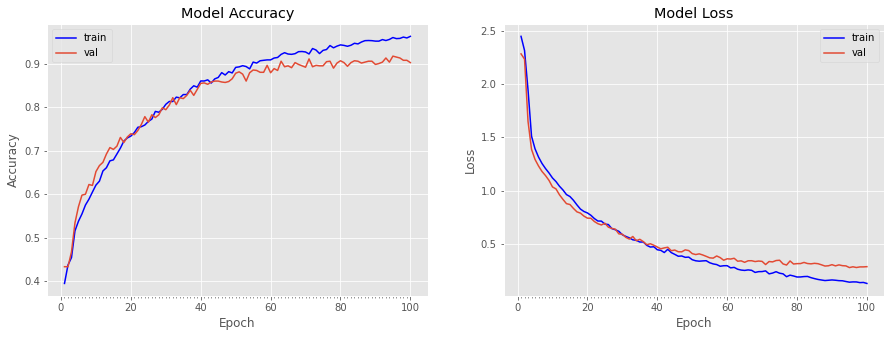

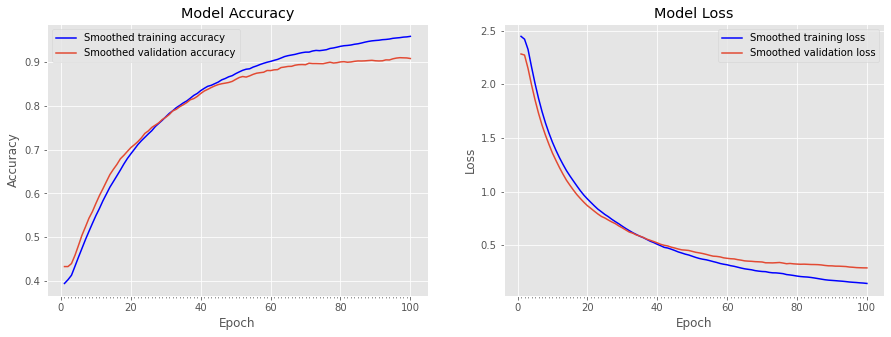

In [39]:
from help import plot_curve,plot_curve_with_smooth
%matplotlib inline
plot_curve(history)
plot_curve_with_smooth(history)

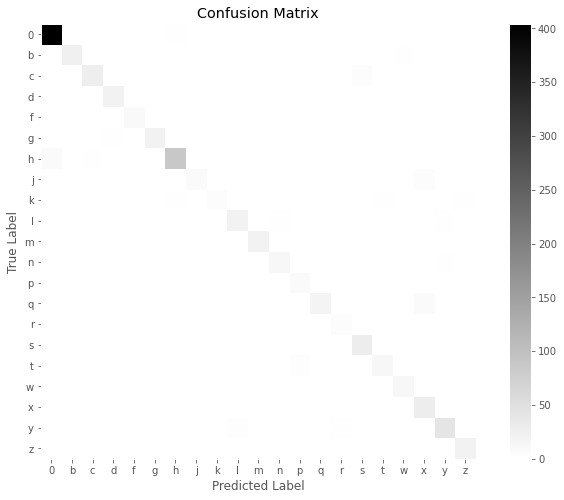

In [40]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
y_pred=merged_model.predict([X_gabor_val,X_mfcc_val])
y_pred=np.argmax(y_pred,axis=-1).ravel()
y_true=np.argmax(y_initial_val,axis=-1).ravel()
con_matrix=confusion_matrix(y_true=y_true,y_pred=y_pred)
target_names=[alphabet_set[i] for i in range(21)]
def plot_confusion_matrix(confusion_mat):
    plt.figure(figsize=(12,8))
    plt.imshow(confusion_mat,cmap='binary')
    plt.title('Confusion Matrix')
    plt.colorbar()
    labels = target_names
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.grid(False)
    plt.show() 
plot_confusion_matrix(con_matrix)

In [41]:
from sklearn.metrics import classification_report
target_names=[alphabet_set[i] for i in range(21)]
print(classification_report(y_true,y_pred,digits=4,labels=list(range(21)),target_names=target_names))

              precision    recall  f1-score   support

           0     0.9782    0.9902    0.9842       408
           b     0.8571    0.8276    0.8421        29
           c     0.8750    0.8000    0.8358        35
           d     0.8462    0.8800    0.8627        25
           f     0.9091    0.9091    0.9091        11
           g     0.8800    0.8800    0.8800        25
           h     0.9462    0.8713    0.9072       101
           j     0.9000    0.5625    0.6923        16
           k     0.8571    0.5000    0.6316        12
           l     0.7857    0.8148    0.8000        27
           m     0.9545    0.9545    0.9545        22
           n     0.8750    0.7778    0.8235        18
           p     0.6154    0.8000    0.6957        10
           q     0.8182    0.6923    0.7500        26
           r     0.7143    0.7143    0.7143         7
           s     0.8286    0.9667    0.8923        30
           t     0.8235    0.6667    0.7368        21
           w     0.7647    

In [5]:
merged_model.load_weights(MODEL_SAVE_PATH)

In [6]:
ID = 'person10_time1_group2_zhong_1'
temp = np.load('./gabor/'+ID+'.npy')
m,n = temp.shape
            #print(m)
if m <=35:
    left = 36 - m
    temp =np.append(temp,(np.zeros([left,n])),axis=0)
test1 =[]
test1.append(temp[:35,])
test1 = np.array(test1)

test2 = np.load('./mfcc_data/'+ID+'.npy')
test2 = test2.reshape(1,50,57)


pred=merged_model.predict([test1,test2])

pred=np.argmax(pred,axis=-1)[0]

text=[alphabet_set[i] for i in pred]
text=[i for i in text if i!='0']
text=''.join(text)
print('Predict Label:%s'%(text))

Predict Label:zh


In [7]:
ID = 'person1_time1_group1_da_4'
temp = np.load('./gabor/'+ID+'.npy')
m,n = temp.shape
            #print(m)
if m <=35:
    left = 36 - m
    temp =np.append(temp,(np.zeros([left,n])),axis=0)
test1 =[]
test1.append(temp[:35,])
test1 = np.array(test1)

test2 = np.load('./mfcc_data/'+ID+'.npy')
test2 = test2.reshape(1,50,57)


pred=merged_model.predict([test1,test2])

pred=np.argmax(pred,axis=-1)[0]

text=[alphabet_set[i] for i in pred]
text=[i for i in text if i!='0']
text=''.join(text)
print('Predict Label:%s'%(text))

Predict Label:y


In [8]:
ID = 'person1_time1_group1_ba_1'
temp = np.load('./gabor/'+ID+'.npy')
m,n = temp.shape
            #print(m)
if m <=35:
    left = 36 - m
    temp =np.append(temp,(np.zeros([left,n])),axis=0)
test1 =[]
test1.append(temp[:35,])
test1 = np.array(test1)

test2 = np.load('./mfcc_data/'+ID+'.npy')
test2 = test2.reshape(1,50,57)


pred=merged_model.predict([test1,test2])

pred=np.argmax(pred,axis=-1)[0]

text=[alphabet_set[i] for i in pred]
text=[i for i in text if i!='0']
text=''.join(text)
print('Predict Label:%s'%(text))

Predict Label:b
